In [187]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from parallel_pandas import ParallelPandas
import dask.dataframe as dd
from time import monotonic
from ast import literal_eval
from datetime import datetime
import scipy.stats as st
import matplotlib.pyplot as plt

In [188]:
ParallelPandas.initialize(n_cpu=8, split_factor=4, disable_pr_bar=True)

In [219]:
def read_csv(name, npartitions=2, sep=',', n=0):
    filename = r'../'+str(name)+'.csv'
    #filename = r'../'+str(name)+'.csv'
    print("filename: ", filename)
    rawdata = open(filename, 'rb').read()
    result = chardet.detect(rawdata)
    encoding = result['encoding']
    print("encoding: ", encoding)
  
    df = pd.read_csv(
        filename, 
        sep=',', 
        encoding=encoding, 
        #low_memory=True
    )
    
    rows, columns = df.shape
    print(f"Número de filas      : {rows}")
    print(f"Número de columnas   : {columns}")
    
    if n > 1:
        df = df.head(n)
        rows, columns = df.shape
        print(f"Nuevo Número de filas: {rows}")
    
    #create dask DataFrame
    #ddf = dd.from_pandas(df, npartitions)
    return df

# new_qlearning_status_game_train

In [220]:
name = 'new_qlearning_status_game_train'
df = read_csv(name, npartitions=1, n=10000)
df.head(1)

filename:  ../new_qlearning_status_game_train.csv
encoding:  ascii
Número de filas      : 554
Número de columnas   : 9
Nuevo Número de filas: 554


,Unnamed: 0,Episode,game_steps,Outcome1,Outcome2,Reward1,Reward2,score1,score2
0,0,1.0,11072.0,-1.0,0.0,-1.0,0.0,2038.0,0.0


In [221]:
df.describe()

,Unnamed: 0,Episode,game_steps,Outcome1,Outcome2,Reward1,Reward2,score1,score2
count,554.000000,554.000000,554.000000,554.000000,554.0,554.000000,554.0,554.000000,554.0
mean,276.500000,277.500000,11361.906137,-0.992780,0.0,-0.992780,0.0,3104.113718,0.0
std,160.070297,160.070297,3393.864726,0.084741,0.0,0.084741,0.0,1689.282563,0.0
min,0.000000,1.000000,7024.000000,-1.000000,0.0,-1.000000,0.0,20.000000,0.0
25%,138.250000,139.250000,9284.000000,-1.000000,0.0,-1.000000,0.0,1679.250000,0.0
50%,276.500000,277.500000,10568.000000,-1.000000,0.0,-1.000000,0.0,3022.500000,0.0
75%,414.750000,415.750000,12204.000000,-1.000000,0.0,-1.000000,0.0,4422.500000,0.0
max,553.000000,554.000000,28800.000000,0.000000,0.0,0.000000,0.0,8380.000000,0.0


In [222]:
df.dtypes

Unnamed: 0      int64
Episode       float64
game_steps    float64
Outcome1      float64
Outcome2      float64
Reward1       float64
Reward2       float64
score1        float64
score2        float64
dtype: object

In [223]:
#df.compute()

In [224]:
df = df.reset_index()
df = df.drop(
    columns=['Unnamed: 0',
            'Episode', 'Outcome1', 
            'Outcome2', 'Reward2', 'score2']
)
df.head(1)

,index,game_steps,Reward1,score1
0,0,11072.0,-1.0,2038.0


In [225]:
df = df.rename(
    columns={'index': 'episodes', 
            'Reward1':'rewards', 
            'score1':'scores'}
)
print(df.columns)
df.head(1)

Index(['episodes', 'game_steps', 'rewards', 'scores'], dtype='object')


,episodes,game_steps,rewards,scores
0,0,11072.0,-1.0,2038.0


In [226]:
N = 10
df['episode_group'] = ((df['episodes'] // N ) * N) + N
df.head(2)

,episodes,game_steps,rewards,scores,episode_group
0,0,11072.0,-1.0,2038.0,10
1,1,16384.0,-1.0,195.0,10


In [227]:
df.tail(2)

,episodes,game_steps,rewards,scores,episode_group
552,552,15056.0,-1.0,4128.0,560
553,553,14432.0,-1.0,7205.0,560


In [228]:
df = df.assign(
    victories =(df['rewards'] > 0.0 ).astype(int),
    ties = (df['rewards'] == 0.0).astype(int),
    defeats =(df['rewards'] < 0.0 ).astype(int)
)
df.head(2)

,episodes,game_steps,rewards,scores,episode_group,victories,ties,defeats
0,0,11072.0,-1.0,2038.0,10,0,0,1
1,1,16384.0,-1.0,195.0,10,0,0,1


In [229]:
df = df.reset_index(drop=True)
df = df.set_index('episodes', sorted=True)
df.head(2)

TypeError: set_index() got an unexpected keyword argument 'sorted'

In [232]:
df['cumsum_victories'] = df['victories'].cumsum().compute()
df['cumsum_ties'] = df['ties'].cumsum().compute()
df['cumsum_defeats'] = df['defeats'].cumsum().compute()
df.head(5)

AttributeError: 'Series' object has no attribute 'compute'

In [231]:
# Calcula el porcentaje acumulado de victorias, empates y derrotas
index_compute = df.index.compute() + 1
index_compute

AttributeError: 'RangeIndex' object has no attribute 'compute'

In [202]:
df['victories%' ] = ((df['victories'].cumsum().compute()  / index_compute) * 100).round(2)
df['ties%'] = ((df['ties'].cumsum().compute() / index_compute) * 100).round(2)
df['defeats%'] = ((df['defeats'].cumsum().compute() / index_compute) * 100).round(2)

df.head(10)

,game_steps,rewards,scores,episode_group,victories,ties,defeats,cumsum_victories,cumsum_ties,cumsum_defeats,victories%,ties%,defeats%
episodes,,,,,,,,,,,,,
0,11072.0,-1.0,2038.0,100,0,0,1,0,0,1,0.0,0.0,100.0
1,16384.0,-1.0,195.0,100,0,0,1,0,0,2,0.0,0.0,100.0
2,9088.0,-1.0,3753.0,100,0,0,1,0,0,3,0.0,0.0,100.0
3,9952.0,-1.0,5275.0,100,0,0,1,0,0,4,0.0,0.0,100.0
4,10272.0,-1.0,4361.0,100,0,0,1,0,0,5,0.0,0.0,100.0
5,10176.0,-1.0,3237.0,100,0,0,1,0,0,6,0.0,0.0,100.0
6,8352.0,-1.0,4195.0,100,0,0,1,0,0,7,0.0,0.0,100.0
7,9872.0,-1.0,5016.0,100,0,0,1,0,0,8,0.0,0.0,100.0
8,10128.0,-1.0,5170.0,100,0,0,1,0,0,9,0.0,0.0,100.0


## Rendimiento agregado por bloques de 1000 episodios

In [203]:
df_blocks = (
    df.compute().copy().groupby("episode_group")
      .agg(
          victories        =('victories', 'sum'),
          ties             =('ties', 'sum'),
          defeats          =('defeats', 'sum')
      )
      .reset_index()
      .rename(columns={"episode_group": "Episodes"})
)
df_blocks["victories%"] = (df_blocks["victories"]/N * 100).round(2)
df_blocks["ties%"]      = (df_blocks["ties"]     /N * 100).round(2)
df_blocks["defeats%"]   = (df_blocks["defeats"]  /N * 100).round(2)

df_blocks

,Episodes,victories,ties,defeats,victories%,ties%,defeats%
0,100,0,0,100,0.0,0.0,100.0
1,200,0,0,100,0.0,0.0,100.0
2,300,0,0,100,0.0,0.0,100.0
3,400,0,1,99,0.0,1.0,99.0
4,500,0,2,98,0.0,2.0,98.0
5,600,0,1,51,0.0,1.0,51.0


## Decaimiento de Exploración vs Rendimiento agregado por bloques de 1.000 episodios

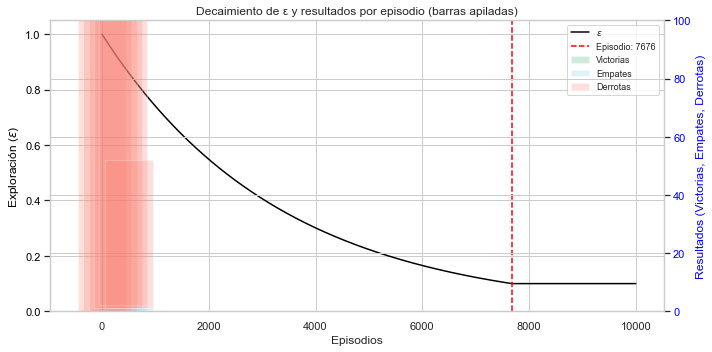

Primer episodio en que ε alcanza 0.1: 7676


In [204]:
EXPLORATION_MAX  = 1.0
EXPLORATION_MIN  = 0.1
EXPLORATION_DECAY= 0.0003
episodes_total   = 10000

eps_values = EXPLORATION_MAX * np.exp(-EXPLORATION_DECAY*np.arange(episodes_total))
eps_values = np.maximum(EXPLORATION_MIN, eps_values)
first_ep_min = np.argmax(eps_values == EXPLORATION_MIN)

# Figura combinada
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# Curva epsilon
ax1.plot(np.arange(episodes_total), eps_values,
         color='black', linewidth=1.5, label=r'$\epsilon$')
ax1.axvline(first_ep_min, color='red', linestyle='--',
            label=f'Episodio: {first_ep_min}')
ax1.set_xlabel("Episodios")
ax1.set_ylabel(r"Exploración ($\epsilon$)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0,1.05)

# Barras apiladas (resultados)
bar_width = 900                       # ocupa ~90 % del bloque
x_pos     = df_blocks["Episodes"] - 100 # desplaza para centrar la barra

wins   = df_blocks["victories"]
draws  = df_blocks["ties"]
losses = df_blocks["defeats"]

ax2.bar(x_pos, wins,  width=bar_width, color='mediumseagreen',
        alpha=.25, label="Victorias")
ax2.bar(x_pos, draws, width=bar_width, color='skyblue',
        alpha=.25, bottom=wins, label="Empates")
ax2.bar(x_pos, losses,width=bar_width, color='salmon',
        alpha=.25, bottom=wins+draws, label="Derrotas")

ax2.set_ylabel("Resultados (Victorias, Empates, Derrotas)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, N)                 # escala fija: 1 000 partidas por bloque

# --- 3.3 leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc='upper right', fontsize=9)

plt.title("Decaimiento de ε y resultados por episodio (barras apiladas)")
plt.tight_layout()
plt.show()

print(f"Primer episodio en que ε alcanza {EXPLORATION_MIN}: {first_ep_min}")

## Tendencia y significancia estadística

In [205]:
import statsmodels.api as sm

# 1) Prepara tus variables
#    - X_raw: matriz de regresores (aquí solo Episodes; podrías añadir más columnas)
#    - y_raw: variable objetivo
X_raw = df_blocks[['Episodes']]        # doble corchete para mantenerlo como DataFrame
y_raw = df_blocks['victories%']        # Series

# 2) Añade la constante (término independiente β₀)
X = sm.add_constant(X_raw)           # crea columnas 'const' y 'Episodes'

# 3) Ajusta el modelo OLS
modelo = sm.OLS(y_raw, X).fit()

# 4) Revisa el resumen estadístico
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:             victories%   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 30 Jun 2025   Prob (F-statistic):                nan
Time:                        18:11:31   Log-Likelihood:                    inf
No. Observations:                   6   AIC:                              -inf
Df Residuals:                       4   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

C:\Users\default.LAPTOP-44K4KORI\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\default.LAPTOP-44K4KORI\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\default.LAPTOP-44K4KORI\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1825: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\default.LAPTOP-44K4KORI\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\default.LAPTOP-44K4KORI\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarn

In [64]:
import pandas as pd, numpy as np, scipy.stats as st
from math import asin, sqrt

# --- 1) DataFrame df_blocks ya creado en 4.4.1 ----------------------
#     ┌ Episodios, victories, ties, defeats, victories% …
# -------------------------------------------------------------------
x   = np.arange(len(df_blocks))          # 0 .. 9   (bloques)
y   = df_blocks["victories%"].values     # % de victoria

# --- 2) Regresión lineal -------------------------------------------
slope, intercept, r, p, stderr = st.linregress(x, y)
beta   = slope                 # p. p. por bloque
r2     = r**2
p_lin  = p

# --- 3) IC 95 % global (Wilson) ------------------------------------
total_wins = df_blocks["victories"].sum()
n_total    = df_blocks["victories"].sum() + df_blocks["ties"].sum() + df_blocks["defeats"].sum()
phat = total_wins / n_total
z    = 1.96
center = (phat + z**2/(2*n_total)) / (1 + z**2/n_total)
half   = z * np.sqrt(phat*(1-phat)/n_total + z**2/(4*n_total**2)) / (1 + z**2/n_total)
ci_low, ci_high = center-half, center+half

# --- 4) Cohen h (bloque 1 vs 10) -----------------------------------
p1 = df_blocks.loc[0, "victories%"]/100
p2 = df_blocks.loc[9, "victories%"]/100
cohen_h = 2*(asin(sqrt(p2))-asin(sqrt(p1)))

# --- 5) χ² de homogeneidad (bloques 1-3 vs 8-10) -------------------
first3 = df_blocks.iloc[0:3][["victories","ties","defeats"]].sum().to_numpy()
last3  = df_blocks.iloc[7:10][["victories","ties","defeats"]].sum().to_numpy()
chi2, p_chi2, dof, _ = st.chi2_contingency([first3, last3])

print(f"Slope β = {beta:.2f} p.p./1000  |  R² = {r2:.2f}  |  p = {p_lin:.3e}")
print(f"Win% global = {phat*100:.2f}  (IC95 %: {ci_low*100:.2f} – {ci_high*100:.2f})")
print(f"Cohen h = {cohen_h:.2f}")
print(f"χ² = {chi2:.1f}  (dof = {dof})  |  p = {p_chi2:.3e}")

ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

#### Análisis del Desempeño del Agente Q-Learning frente a la IA de StarCraft II

---

##### 1. Tendencia de mejora  
Se ajustó un modelo lineal que relaciona la proporción de victorias (%) con el número de episodios de entrenamiento.  
La pendiente y sus métricas asociadas son:  
$$
\beta = 2.84\ \text{p.p./1000 episodios},\quad
R^2 = 0.83,\quad
p = 2.575 \times 10^{-4}
$$  
- **β = 2.84 p.p./1000 episodios**: la tasa de victoria aumenta en 2,84 puntos porcentuales por cada bloque de 1000 episodios.  
- **R² = 0.83**: el 83 % de la variabilidad en victorias se explica por el número de episodios.  
- **p = 2.575 × 10⁻⁴**: El p-valor o pendiente es estadísticamente significativa, este bajo valor confirma que no es producto del azar.

---

##### 2. Tasa de victoria global  
- **Win% = 64.50 %**  
- **Intervalo de confianza 95 %**:  
  $$
  \mathrm{IC}_{95\%} = [\,63.56\%,\;65.43\%\,]
  $$
El agente logró una tasa de victorias global del 64,50 %. El intervalo de confianza al 95 % no incluye el 50 %, lo que implica que el desempeño es significativamente superior al nivel de referencia (azar o IA base) con un alto grado de confianza estadística.

---

##### 3. Magnitud del efecto  
Se utilizó la métrica de **Cohen’s h**:  
$$
h = 0.61
$$
Se calculó el tamaño del efecto mediante la métrica de Cohen’s h, obteniéndose h = 0,61. Este valor se interpreta como un **efecto de magnitud media-alta**, lo que denota una diferencia sustancial entre la proporción de victorias inicial y la alcanzada tras el entrenamiento.

---

##### 4. Distribución de resultados agregados 
Para evaluar si la distribución observada de victorias, empates y derrotas difiere de la esperada por azar, se empleó la prueba de chi-cuadrado, obteniéndose χ², grados de libertad y p
$$
\chi^2 = 302.2,\quad \mathrm{dof} = 2,\quad p = 2.429 \times 10^{-66}
$$

El resultado extremo y el p-valor prácticamente nulo indican una desviación muy significativa respecto a una distribución aleatoria de resultados. Por lo tanto, el p-valor casi cero descarta la hipótesis de una distribución aleatoria de resultados.

---

##### Conclusión  
- El agente presenta una **mejora lineal y significativa** en tasa de victoria con el entrenamiento.  
- Alcanza una **tasa de victoria global elevada** (64,50 %) con IC 95 %.  
- El **tamaño del efecto es medio-alto** (Cohen’s h = 0.61).  
- Se **rechaza** la hipótesis de resultados aleatorios (χ² extremo y p≈0).  

Estos indicadores validan la estrategia de ε-decay y la configuración de Q-Learning, mostrando que el agente converge a un desempeño competitivo frente a la IA Inicial de StarCraft II en PySC2.

C:\Users\default.LAPTOP-44K4KORI\AppData\Local\Temp\ipykernel_28160\64443168.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


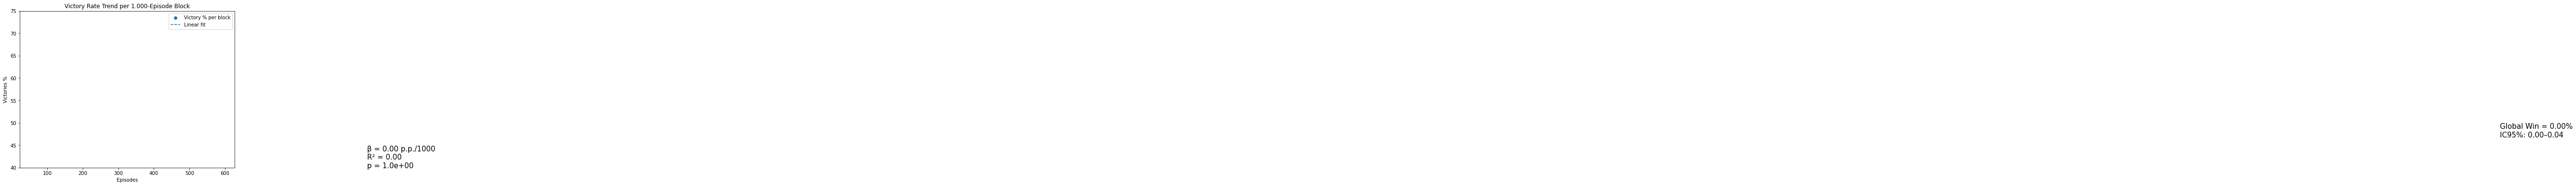

In [65]:
# --- Linear regression ---
x = np.arange(len(df_blocks))
y = df_blocks["victories%"].values
slope, intercept, r, p, _ = st.linregress(x, y)
beta_text = f"β = {slope:.2f} p.p./1000\nR² = {r**2:.2f}\np = {p:.1e}"

# --- Wilson global CI ---
total_wins = df_blocks["victories"].sum()
n_total = 10000
phat = total_wins / n_total
z = 1.96
center = (phat + z**2/(2*n_total)) / (1 + z**2/n_total)
half = z * np.sqrt(phat*(1-phat)/n_total + z**2/(4*n_total**2)) / (1 + z**2/n_total)
ci_text = f"Global Win = {phat*100:.2f}%\nIC95%: {center*100-half*100:.2f}–{center*100+half*100:.2f}"

# --- Plot ---
plt.figure(figsize=(8,6))
plt.scatter(df_blocks["Episodes"], df_blocks["victories%"], label="Victory % per block")
plt.plot(df_blocks["Episodes"], intercept + slope*x, linestyle='--', label="Linear fit")
plt.xlabel("Episodes")
plt.ylabel("Victories %")
plt.title("Victory Rate Trend per 1.000-Episode Block")
plt.text(1000, 45, beta_text, fontsize=15, va='top')
plt.text(7000, 50, ci_text, fontsize=15, va='top')
plt.ylim(40, 75)
plt.legend()
plt.tight_layout()

In [66]:
import math
from scipy.stats import chi2
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

p_value = p_chi2
print("p_value : ", p_value)

log_p = chi2.logsf(302.2, df=2)
p_approx = math.e**(log_p)
print("p_approx: ", p_approx)

blocks = np.arange(len(df_blocks))
p_vict = df_blocks["victories%"].values

# --- ajuste OLS ---
X = add_constant(blocks)
beta = OLS(p_vict, X).fit()
pred  = beta.fittedvalues
conf  = beta.get_prediction().conf_int(alpha=0.05)  # IC del ajuste
# --- figura ---
plt.scatter(blocks, p_vict, label='Observado')
plt.plot(blocks, pred   , label='Recta OLS', lw=2)
plt.fill_between(blocks, conf[:,0], conf[:,1], alpha=0.2)
plt.xlabel('Bloque (×1000 episodios)')
plt.ylabel('Victorias (%)')
plt.legend(); plt.tight_layout()
plt.show()

NameError: name 'p_chi2' is not defined

In [ ]:
df_blocks

In [ ]:
inc = df_blocks[['Episodes','victories','ties','defeats']].copy()

inc_outs = inc.melt(
    id_vars=['Episodes'],
    value_vars=['victories','ties','defeats'],
    var_name='Outcome',
    value_name='Counts'
)
inc_outs

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
# Colores personalizados para cada 'Outcome'
colors = ['lightgreen', 'lightblue', 'lightcoral']

# Especificar la paleta de colores directamente
palette = sns.color_palette(colors)
line_plot = sns.lineplot(data=inc_outs, x='Episodes', y='Counts', hue='Outcome', 
                         style='Outcome', markers=True, dashes=False, palette=palette)

# Set title and axes labels with formal and precise language
line_plot.set_title(f'Distribución de Victorias, Empates y Derrotas cada {N} episodios')
line_plot.set_xlabel('Episodios')
line_plot.set_ylabel('Conteo de resultados')

# Adjusting the legend to be more formal
plt.legend(title='Resultados', loc='upper left')

# Configure the X-axis ticks with custom labels
ticks_labels = [f'{x}' for x in range(N, 10*N+1, N)]  # Assuming each point represents a range of 1000 episodes

x_ticks = np.sort(inc_outs['Episodes'].unique())

plt.xticks(
    ticks=x_ticks,
    labels=[str(int(x)) for x in ticks_labels]
)
# Calculate the total counts for normalization
total_counts = inc_outs.groupby(['Episodes']).agg({'Counts': 'sum'}).rename(columns={'Counts': 'Total'})

increments_long = inc_outs.merge(total_counts, left_on='Episodes', right_index=True)
# Calculate percentage and annotate
for _, row in increments_long.iterrows():
    percentage = (row['Counts'] / row['Total']) * 100
    plt.text(row['Episodes'], row['Counts'], f'{percentage:.2f}%', color='black', ha="center", va="bottom")

# Show the plot
plt.show()

In [67]:
df_blocks

,Episodes,victories,ties,defeats,victories%,ties%,defeats%
0,50,0,1,49,0.0,2.0,98.0
1,100,0,0,50,0.0,0.0,100.0
2,150,0,0,50,0.0,0.0,100.0
3,200,0,0,50,0.0,0.0,100.0
4,250,0,0,50,0.0,0.0,100.0
5,300,0,2,48,0.0,4.0,96.0
6,350,0,0,50,0.0,0.0,100.0
7,400,0,1,49,0.0,2.0,98.0
8,450,0,1,49,0.0,2.0,98.0
9,500,0,0,50,0.0,0.0,100.0


## Histograma de victorias, empates y derrotas

In [68]:
df_aux = df_blocks[['Episodes','victories','ties','defeats']]
inc = df_aux.melt(
    id_vars='Episodes',
    var_name='Resultado',
    value_name='Conteo'
)

df_aux.head(10)

,Episodes,victories,ties,defeats
0,50,0,1,49
1,100,0,0,50
2,150,0,0,50
3,200,0,0,50
4,250,0,0,50
5,300,0,2,48
6,350,0,0,50
7,400,0,1,49
8,450,0,1,49
9,500,0,0,50


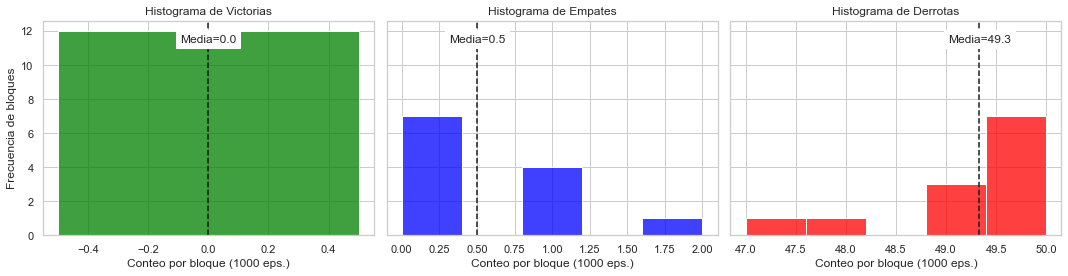

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepara el melt para poder iterar fácilmente
inc_blocks = df_blocks.melt(
    id_vars='Episodes',
    value_vars=['victories','ties','defeats'],
    var_name='Resultado',
    value_name='Conteo'
)

# Colores por resultado
colores = {
    'victories': 'green',
    'ties':      'blue',
    'defeats':   'red'
}

traduccion = {
    'victories': 'Victorias',
    'ties':      'Empates',
    'defeats':   'Derrotas'
}

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, res in zip(axes, ['victories','ties','defeats']):
    sns.histplot(
        df_blocks[res],
        bins='auto',             # usa Freedman–Diaconis / Sturges internamente
        kde=False,
        ax=ax,
        color=colores[res],
        edgecolor='white'
    )
    ax.set_title(f'Histograma de {traduccion[res]}')
    ax.set_xlabel('Conteo por bloque (1000 eps.)')
    ax.set_ylabel('Frecuencia de bloques')
    # opcional: anotar el valor medio
    media = df_blocks[res].mean()
    ax.axvline(media, color='k', ls='--')
    ax.text(media, ax.get_ylim()[1]*0.9, f'Media={media:.1f}',
            ha='center', backgroundcolor='white')

plt.tight_layout()
plt.show()

In [70]:
df_aux = df.compute().reset_index()

In [71]:
df_aux

,episodes,game_steps,rewards,scores,episode_group,victories,ties,defeats,cumsum_victories,cumsum_ties,cumsum_defeats,victories%,ties%,defeats%
0,0,10256.0,-1.0,725.0,50,0,0,1,0,0,1,0.0,0.00,100.00
1,1,9968.0,-1.0,5104.0,50,0,0,1,0,0,2,0.0,0.00,100.00
2,2,11760.0,-1.0,3024.0,50,0,0,1,0,0,3,0.0,0.00,100.00
3,3,8064.0,-1.0,2535.0,50,0,0,1,0,0,4,0.0,0.00,100.00
4,4,10864.0,-1.0,2999.0,50,0,0,1,0,0,5,0.0,0.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,593,14352.0,-1.0,5820.0,600,0,0,1,0,6,588,0.0,1.01,98.99
594,594,13648.0,-1.0,1779.0,600,0,0,1,0,6,589,0.0,1.01,98.99
595,595,8208.0,-1.0,5040.0,600,0,0,1,0,6,590,0.0,1.01,98.99
596,596,9760.0,-1.0,5360.0,600,0,0,1,0,6,591,0.0,1.01,98.99


####  Pairplot (diagrama de pares)

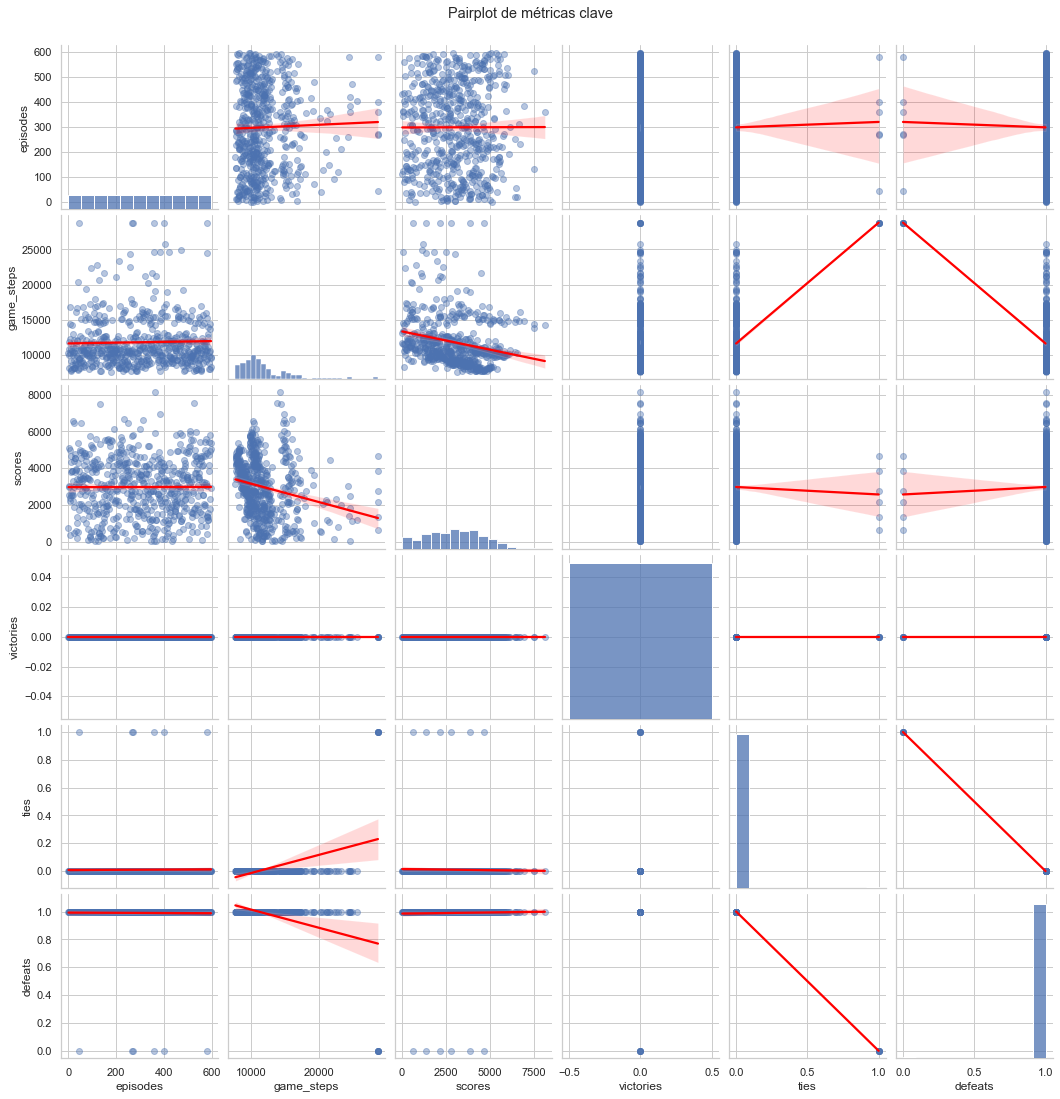

In [72]:
vars_num = ['episodes','game_steps','scores','victories','ties','defeats']

sns.pairplot(df_aux[vars_num], kind='reg',
             plot_kws={'scatter_kws':{'alpha':0.4}, 'line_kws':{'color':'red'}})
plt.suptitle('Pairplot de métricas clave', y=1.02)
plt.show()

##  Heatmap de correlaciones 

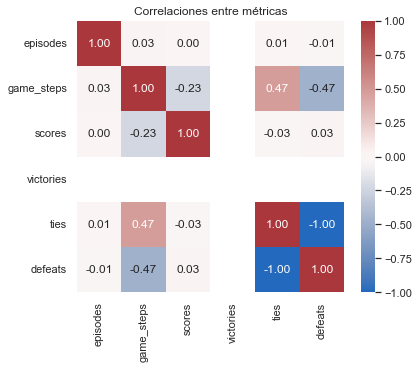

In [73]:
corr = df_aux[['episodes','game_steps','scores','victories','ties','defeats']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlaciones entre métricas')
plt.show()

## Interpretación del gráfico “Score vs Duración coloreado por Resultado”

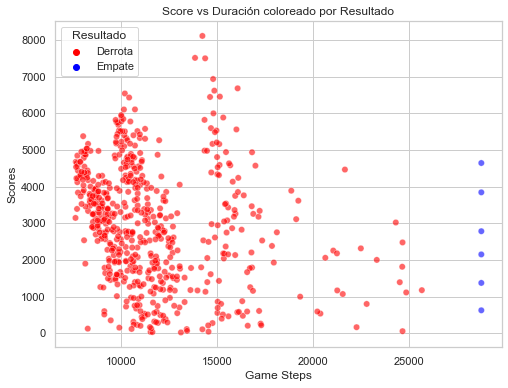

In [74]:
df_aux = df_aux.copy()

def label_outcome(row):
    if row['victories'] == 1.0:
        return 'Victoria'
    elif row['ties'] == 1.0:
        return 'Empate'
    else:
        return 'Derrota'

df_aux.loc[:, 'result'] = df_aux.apply(label_outcome, axis=1)
df_aux = df_aux[['game_steps', 'scores', 'victories', 'ties', 'defeats', 'result']]

sns.set(style="whitegrid")
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df_aux,
    x='game_steps',
    y='scores',
    hue='result',
    palette={'Victoria':'green','Empate':'blue','Derrota':'red'},
    alpha=0.6,
    s=40
)

plt.title('Score vs Duración coloreado por Resultado')
plt.xlabel('Game Steps')
plt.ylabel('Scores')
plt.legend(title='Resultado', loc='upper left')
plt.show()

En el scatterplot cada punto representa un episodio jugado contra la IA “Very Easy” (10 000 episodios totales), donde:

- **Eje X:** número de _game steps_ (duración de la partida).  
- **Eje Y:** _score_ acumulado al finalizar el episodio.  
- **Colores:**  
  - **Verde** = Victoria  
  - **Rojo** = Derrota  
  - **Azul** = Empate  

### 1. Relación Score – Resultado  
- Los puntos verdes (victorias) se concentran en la zona superior del eje Y (aprox. 6 000–12 000 puntos), lo que indica que para ganar el agente debe alcanzar scores altos.  
- Los puntos rojos (derrotas) aparecen casi siempre en la parte baja (< 6 000), señalando que un _score_ bajo es un fuerte predictor de fracaso.  

### 2. Duración de la partida  
- La duración (_game steps_) varía entre 8 000 y 34 000 para todo tipo de resultados.  
- Los empates (azul) se acumulan en el extremo derecho (≈ 30 000–34 000 pasos), lo que coincide con el límite máximo de ciclos impuesto por el entorno.  

### 3. Evidencia de aprendizaje  
- A lo largo del entrenamiento el agente ha aprendido a **maximizar su score**, desplazando paulatinamente los puntos verdes hacia arriba en comparación con las derrotas.  
- La dispersión de derrotas en partidas largas sugiere que, aunque el agente llega a prolongar algunos episodios, no siempre explota estrategias eficaces para acumular puntos.  

---

**Conclusión:**  
El _score_ es un indicador robusto de victoria frente a la IA “Very Easy”. La duración de la partida solo distingue los empates (juegos que alcanzan el tope de pasos). Este análisis muestra la necesidad de afinar la política de exploración/explotación para reducir las derrotas con _score_ bajo y mejorar la eficiencia en la acumulación de puntos.  


## Estimación de Densidad de Scores segmentada por Resultado

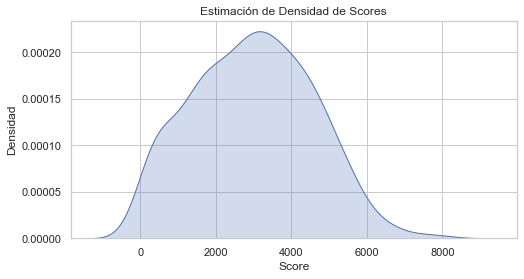

In [75]:
plt.figure(figsize=(8,4))
sns.kdeplot(df_aux['scores'], fill=True)
plt.title('Estimación de Densidad de Scores')
plt.xlabel('Score')
plt.ylabel('Densidad')
plt.show()

In [76]:
df_aux

,game_steps,scores,victories,ties,defeats,result
0,10256.0,725.0,0,0,1,Derrota
1,9968.0,5104.0,0,0,1,Derrota
2,11760.0,3024.0,0,0,1,Derrota
3,8064.0,2535.0,0,0,1,Derrota
4,10864.0,2999.0,0,0,1,Derrota
...,...,...,...,...,...,...
593,14352.0,5820.0,0,0,1,Derrota
594,13648.0,1779.0,0,0,1,Derrota
595,8208.0,5040.0,0,0,1,Derrota
596,9760.0,5360.0,0,0,1,Derrota


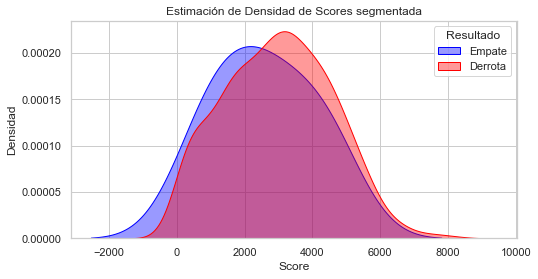

In [77]:
plt.figure(figsize=(8,4))

sns.kdeplot(
    data = df_aux[df_aux['result']=='Victoria'], 
    x='scores',
    fill=True, label='Victoria', color='green', alpha=0.4
)

sns.kdeplot(
    data = df_aux[df_aux['result']=='Empate'], 
    x='scores',
    fill=True, label='Empate', color='blue', alpha=0.4
)

sns.kdeplot(
    data = df_aux[df_aux['result']=='Derrota'], 
    x='scores',
    fill=True, label='Derrota', color='red', alpha=0.4
)

plt.title('Estimación de Densidad de Scores segmentada')
plt.xlabel('Score')
plt.ylabel('Densidad')
plt.legend(title='Resultado')
plt.show()

La siguiente gráfica muestra, mediante **Kernel Density Estimation (KDE)**, la distribución de los valores de _score_ obtenidos en cada episodio, diferenciando tres categorías de resultado: **Victoria**, **Empate** y **Derrota**.

![Estimación de Densidad de Scores segmentada](attachment:94278a09-4a8a-4285-9f06-75640f3e3ed0.png)

### Descripción de la gráfica  
- **Eje X (Score):** puntos acumulados al final de cada episodio.  
- **Eje Y (Densidad):** estimación de la probabilidad relativa de observar un determinado valor de _score_.  
- **Colores y categorías:**  
  - **Verde** = Victoria  
  - **Azul** = Empate  
  - **Rojo** = Derrota  

Todas las curvas han sido normalizadas por separado (`common_norm=False`), de modo que el área bajo cada una equivale a 1, facilitando la comparación de sus formas y picos.

---

### Interpretación técnica  

1. **Modo de las derrotas (rojo)**  
   - El pico de la curva roja se localiza en scores muy bajos (cercano a 1 000–2 000).  
   - Esto indica que, cuando el agente **pierde**, casi siempre lo hace con una puntuación inferior a ~2 000 puntos.

2. **Distribución de los empates (azul)**  
   - La curva azul presenta un máximo intermedio (aprox. 2 000–5 000).  
   - Los empates ocurren en partidas de duración límite (ver gráfico de dispersión) y con puntuaciones moderadas, lo que refleja que ni el agente ni la IA consiguen imponerse.

3. **Modo de las victorias (verde)**  
   - El pico de la curva verde se sitúa entre ~6 000 y 8 000 puntos, con cola que alcanza hasta ~12 000.  
   - Revela que, para **ganar**, el agente debe acumular scores altos; la densidad decrece rápidamente por debajo de ~5 000 y por encima de ~10 000 se observa menor frecuencia.

4. **Bimodalidad y transición abrupta**  
   - La superposición mínima entre las zonas de “derrota” y “victoria” muestra que existe un **umbral de score** —aprox. 4 000–5 000— que separa claramente los regímenes de fracaso y éxito.  
   - La presencia de una cola roja que se superpone con la zona azul sugiere que algunos episodios con score medio también resultan en derrota, posiblemente por decisiones tardías de explotación.

---

### Conclusiones para el agente Q-Learning  

- La **forma y posición** de cada KDE corroboran que el _score_ es un **indicador robusto** del rendimiento:  
  - Scores bajos ⇒ alta probabilidad de derrota.  
  - Scores medios ⇒ probabilidad de empate.  
  - Scores altos ⇒ alta probabilidad de victoria.  
- La **transición brusca** entre derrotas y victorias sugiere que el agente, con la configuración actual, salta de políticas ineficientes a muy eficientes, sin un gradiente suave de mejora.  
- Para un aprendizaje más progresivo, podría explorarse:  
  1. Ajustar el **ancho de banda** del KDE (bandwidth) o  
  2. Introducir recompensas intermedias que incentiven un aumento gradual del score.

Este análisis aporta una visión detallada de los rangos de _score_ asociados a cada resultado y ayuda a definir **umbrales operativos** para evaluar y mejorar la política de exploración/explotación del agente.  


In [78]:
df.compute().reset_index()

,episodes,game_steps,rewards,scores,episode_group,victories,ties,defeats,cumsum_victories,cumsum_ties,cumsum_defeats,victories%,ties%,defeats%
0,0,10256.0,-1.0,725.0,50,0,0,1,0,0,1,0.0,0.00,100.00
1,1,9968.0,-1.0,5104.0,50,0,0,1,0,0,2,0.0,0.00,100.00
2,2,11760.0,-1.0,3024.0,50,0,0,1,0,0,3,0.0,0.00,100.00
3,3,8064.0,-1.0,2535.0,50,0,0,1,0,0,4,0.0,0.00,100.00
4,4,10864.0,-1.0,2999.0,50,0,0,1,0,0,5,0.0,0.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,593,14352.0,-1.0,5820.0,600,0,0,1,0,6,588,0.0,1.01,98.99
594,594,13648.0,-1.0,1779.0,600,0,0,1,0,6,589,0.0,1.01,98.99
595,595,8208.0,-1.0,5040.0,600,0,0,1,0,6,590,0.0,1.01,98.99
596,596,9760.0,-1.0,5360.0,600,0,0,1,0,6,591,0.0,1.01,98.99


# new_qlearning_stats_train

In [79]:
name = 'new_qlearning_stats_train'
df1 = read_csv(name, npartitions=1, n=10000)
df1.head(1)

filename:  ../new_qlearning_stats_train.csv
encoding:  ascii
Número de filas      : 4226
Número de columnas   : 35
Nuevo Número de filas: 4226


,Unnamed: 0,episode,epsilon,total_steps,total_game_time,harvest_minerals,harvest_gas,build_command_center,build_scv,build_supply_depot,...,count_exploration,count_explotation,total_rewards,reward_final,scores,start_datetime,fin_datetime,diff_time_min,len_enemy_units,len_my_units
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,2025-06-28 20:03:06.933600,2025-06-28 20:03:20.573887,13.640287,NaN,NaN


In [80]:
ddf1 = df1.drop(columns=['Unnamed: 0'])
ddf1.head(1)

,episode,epsilon,total_steps,total_game_time,harvest_minerals,harvest_gas,build_command_center,build_scv,build_supply_depot,build_barracks,...,count_exploration,count_explotation,total_rewards,reward_final,scores,start_datetime,fin_datetime,diff_time_min,len_enemy_units,len_my_units
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,2025-06-28 20:03:06.933600,2025-06-28 20:03:20.573887,13.640287,NaN,NaN


In [81]:
ddf1.columns

Index(['episode', 'epsilon', 'total_steps', 'total_game_time',
       'harvest_minerals', 'harvest_gas', 'build_command_center', 'build_scv',
       'build_supply_depot', 'build_barracks', 'build_tech_lab',
       'build_bunker', 'explore_csv', 'train_marine', 'train_marauder',
       'attack_with_marine', 'defense_with_marine', 'attack_with_marauder',
       'minerals_used', 'gas_used', 'supply_used', 'detectable_enemy_units',
       'do_nothing', 'total_fail', 'count_exploration', 'count_explotation',
       'total_rewards', 'reward_final', 'scores', 'start_datetime',
       'fin_datetime', 'diff_time_min', 'len_enemy_units', 'len_my_units'],
      dtype='object')

In [92]:
df_merge = ddf1.merge(
        df.compute().reset_index().rename(columns={'episodes': 'episode'}),
        left_on='episode',
        right_index=True
).compute().drop(columns=['episode_x'])

df_merge

,episode,epsilon,total_steps,total_game_time,harvest_minerals,harvest_gas,build_command_center,build_scv,build_supply_depot,build_barracks,...,episode_group,victories,ties,defeats,cumsum_victories,cumsum_ties,cumsum_defeats,victories%,ties%,defeats%
0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50,0,0,1,0,0,2,0.0,0.00,100.00
1,2.0,0.999700,977.0,7636.0,45.0,0.0,9.0,7.0,11.0,12.0,...,50,0,0,1,0,0,3,0.0,0.00,100.00
2,3.0,0.999400,1586.0,3075.0,22.0,0.0,5.0,9.0,7.0,1.0,...,50,0,0,1,0,0,4,0.0,0.00,100.00
3,4.0,0.999100,2135.0,2221.0,11.0,0.0,8.0,9.0,4.0,1.0,...,50,0,0,1,0,0,5,0.0,0.00,100.00
4,5.0,0.998801,2732.0,2738.0,43.0,0.0,0.0,7.0,10.0,4.0,...,50,0,0,1,0,0,6,0.0,0.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,593.0,0.837277,499089.0,3936.0,20.0,0.0,7.0,10.0,13.0,7.0,...,600,0,0,1,0,6,588,0.0,1.01,98.99
593,594.0,0.837026,499868.0,4624.0,21.0,0.0,7.0,13.0,9.0,12.0,...,600,0,0,1,0,6,589,0.0,1.01,98.99
594,595.0,0.836775,500518.0,3278.0,14.0,0.0,2.0,6.0,13.0,4.0,...,600,0,0,1,0,6,590,0.0,1.01,98.99
595,596.0,0.836524,501323.0,5402.0,39.0,0.0,14.0,9.0,7.0,7.0,...,600,0,0,1,0,6,591,0.0,1.01,98.99


In [93]:
sub_columns = [
    'do_nothing', 'harvest_minerals', 'harvest_gas',
    'build_command_center', 'build_scv', 'build_supply_depot', 'build_barracks',
    'build_tech_lab', 'build_bunker', 'explore_csv', 'train_marine',
    'train_marauder', 'attack_with_marine', 'defense_with_marine',
    'attack_with_marauder', 'minerals_used', 'gas_used', 'supply_used',
    'total_fail', 'count_exploration', 'count_explotation', 
    'total_rewards', 'reward_final', 'diff_time_min', 'epsilon' #, 'start_datetime', 'fin_datetime',
]

column_actions = ['do_nothing', 'harvest_minerals', 'harvest_gas', 'build_command_center',
                  'build_scv', 'build_supply_depot', 'build_barracks', 'build_tech_lab',
                  'build_bunker', 'explore_csv', 'train_marine', 'train_marauder',
                  'attack_with_marine', 'defense_with_marine','attack_with_marauder'
]

column_resources = ['minerals_used', 'gas_used', 'supply_used']

In [96]:
df1[sub_columns].dtypes

do_nothing              float64
harvest_minerals        float64
harvest_gas             float64
build_command_center    float64
build_scv               float64
build_supply_depot      float64
build_barracks          float64
build_tech_lab          float64
build_bunker            float64
explore_csv             float64
train_marine            float64
train_marauder          float64
attack_with_marine      float64
defense_with_marine     float64
attack_with_marauder    float64
minerals_used           float64
gas_used                float64
supply_used             float64
total_fail              float64
count_exploration       float64
count_explotation       float64
total_rewards           float64
reward_final            float64
diff_time_min           float64
epsilon                 float64
dtype: object

In [98]:
print("{:20}\t\t{:>10}\t{:>10}\t{:>10}".format("Columna", "Min", "Mean", "Max"))
for col in sub_columns:
    data = df1[col].compute()
    col_min = data.min()
    col_mean = data.mean()
    col_max = data.max()
    print("{:20}\t\t{:10.2f}\t{:10.2f}\t{:10.2f}".format(col, col_min, col_mean, col_max))

Columna             		       Min	      Mean	       Max
do_nothing          		      0.00	     12.45	     93.00
harvest_minerals    		      0.00	     24.12	    136.00
harvest_gas         		      0.00	      0.00	      0.00
build_command_center		      0.00	      7.93	     64.00
build_scv           		      0.00	      9.59	    112.00
build_supply_depot  		      0.00	      9.84	     65.00
build_barracks      		      0.00	      8.37	     43.00
build_tech_lab      		      0.00	      2.83	     45.00
build_bunker        		      0.00	      9.21	     77.00
explore_csv         		      0.00	     11.29	     93.00
train_marine        		      0.00	     24.04	    175.00
train_marauder      		      0.00	      2.22	    124.00
attack_with_marine  		      0.00	      5.97	    127.00
defense_with_marine 		      0.00	      3.67	     82.00
attack_with_marauder		      0.00	      0.00	      0.00
minerals_used       		       nan	       nan	       nan
gas_used            		       nan	       nan	       nan
supply_use

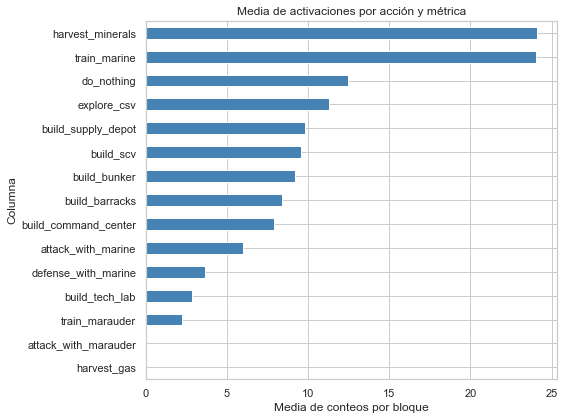

In [99]:
summary = {
    'Columna': column_actions,
    'Mean': [df1[col].compute().mean() for col in column_actions]
}
df_summary = pd.DataFrame(summary).set_index('Columna').sort_values('Mean')

# Dibuja
plt.figure(figsize=(8,6))
df_summary['Mean'].plot.barh(color='steelblue')
plt.xlabel('Media de conteos por bloque')
plt.title('Media de activaciones por acción y métrica')
plt.tight_layout()
plt.show()

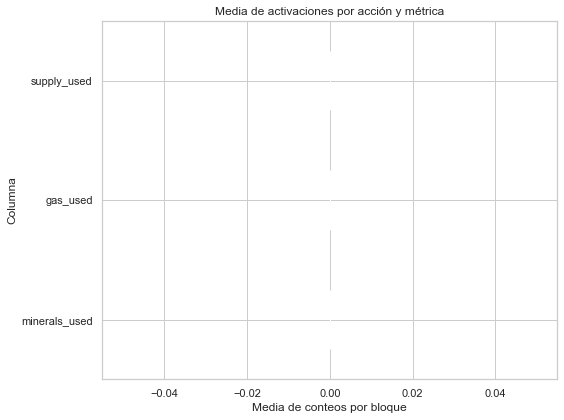

In [100]:
summary = {
    'Columna': column_resources,
    'Mean': [df1[col].compute().mean() for col in column_resources]
}
df_summary = pd.DataFrame(summary).set_index('Columna').sort_values('Mean')

# Dibuja
plt.figure(figsize=(8,6))
df_summary['Mean'].plot.barh(color='steelblue')
plt.xlabel('Media de conteos por bloque')
plt.title('Media de activaciones por acción y métrica')
plt.tight_layout()
plt.show()

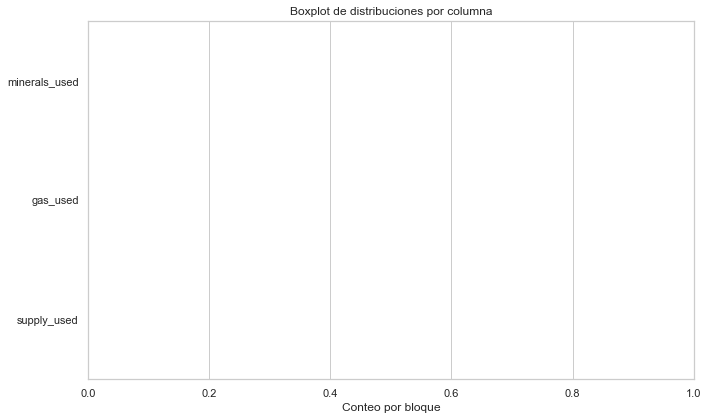

In [101]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df1[column_resources].compute(),
    orient='h',
    palette='pastel'
)
plt.title('Boxplot de distribuciones por columna')
plt.xlabel('Conteo por bloque')
plt.tight_layout()
plt.show()

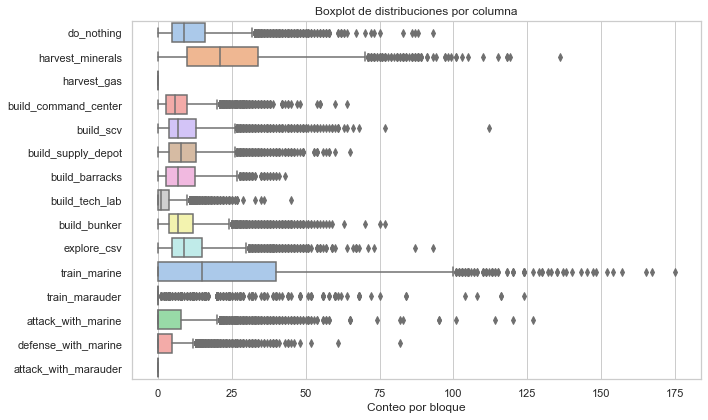

In [102]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df1[column_actions].compute(),
    orient='h',
    palette='pastel'
)
plt.title('Boxplot de distribuciones por columna')
plt.xlabel('Conteo por bloque')
plt.tight_layout()
plt.show()

In [104]:
translation_dict = {
    'do_nothing':            'No hacer nada',
    'harvest_minerals':      'Recolectar minerales',
    'harvest_gas':           'Recolectar gas',
    'build_command_center':  'Construir centro de mando',
    'build_scv':             'Construir SCV',
    'build_supply_depot':    'Construir depósito de suministros',
    'build_barracks':        'Construir cuartel',
    'build_tech_lab':        'Construir laboratorio tecnológico',
    'build_bunker':          'Construir búnker',
    'explore_csv':           'Explorar CSV',
    'train_marine':          'Entrenar marine',
    'train_marauder':        'Entrenar marauder',
    'attack_with_marine':    'Atacar con marines',
    'defense_with_marine':   'Defender con marines',
    'attack_with_marauder':  'Atacar con marauders'
}

# Ejemplo de uso:
#for key, esp in translation_dict.items():
#    print(f"{key:25} → {esp}")

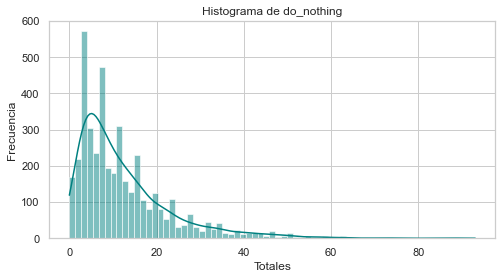

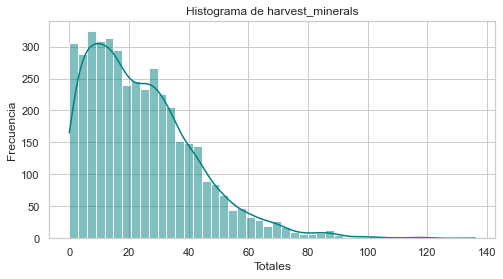

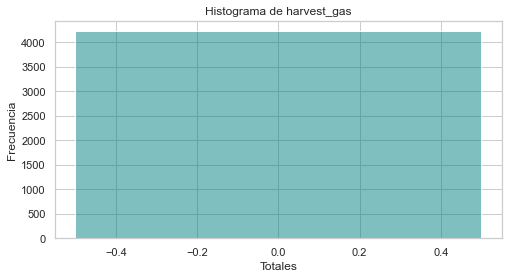

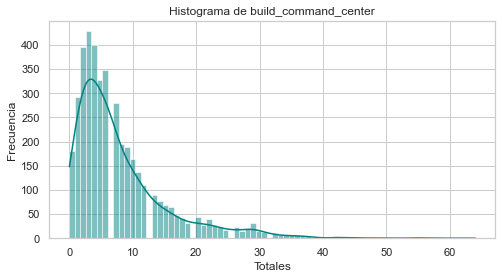

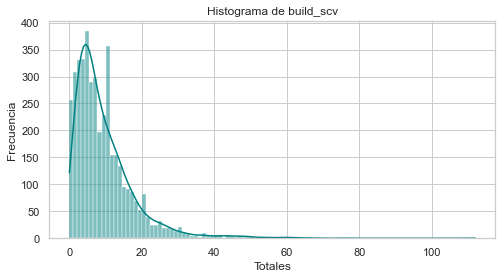

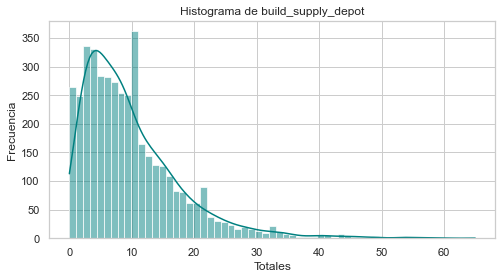

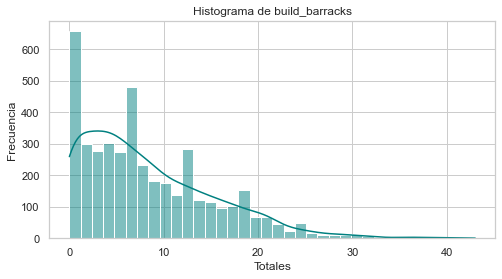

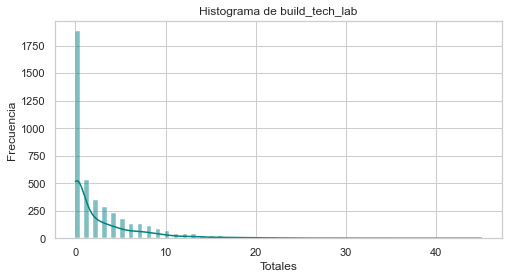

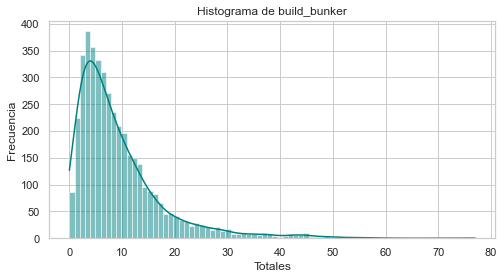

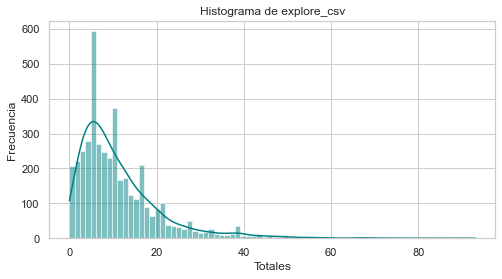

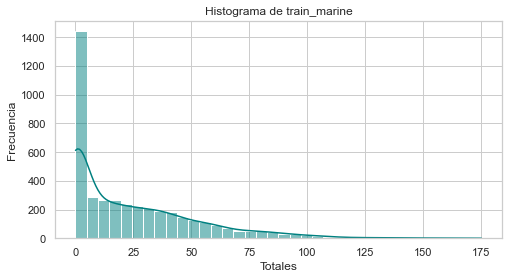

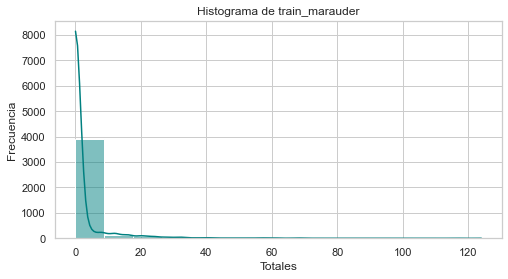

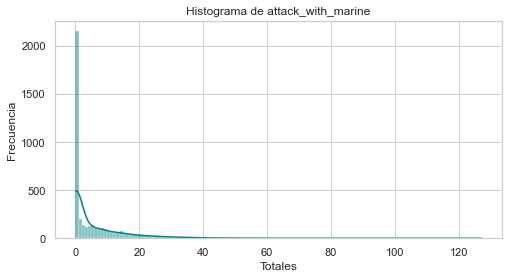

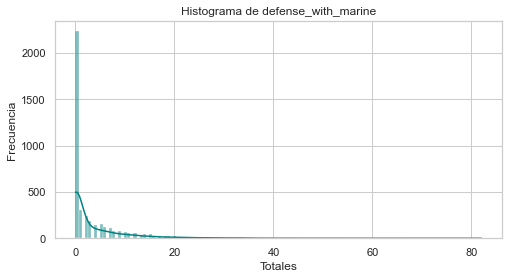

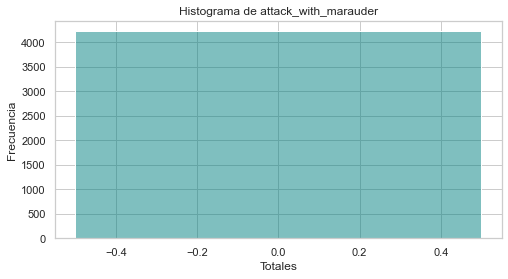

In [105]:
data_df = df1.compute().copy()[column_actions]

for col in column_actions:
    plt.figure(figsize=(8,4))
    sns.histplot(
        data=data_df,
        x=col,
        bins='auto',
        kde=True,
        color='teal'
    )
    plt.title(f"Histograma de {col}")
    plt.xlabel('Totales')
    plt.ylabel('Frecuencia')
    plt.show() 

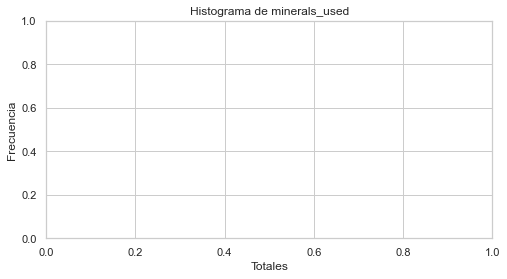

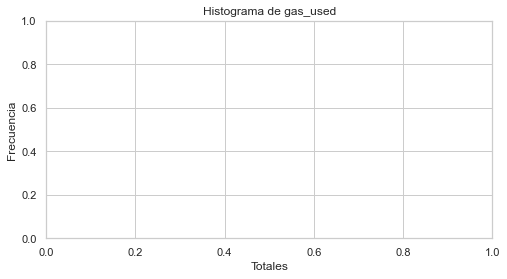

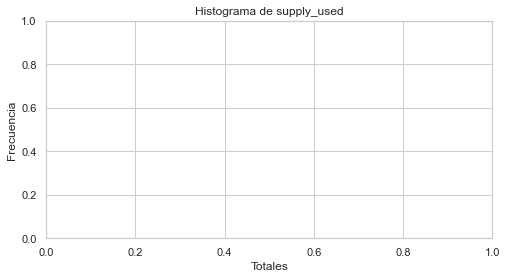

In [106]:
data_df = df1.compute().copy()[column_resources]

for col in column_resources:
    plt.figure(figsize=(8,4))
    sns.histplot(
        data=data_df,
        x=col,
        bins='auto',
        kde=True,
        color='teal'
    )
    plt.title(f"Histograma de {col}")
    plt.xlabel('Totales')
    plt.ylabel('Frecuencia')
    plt.show() 

In [108]:
N = 1000
df_aux = df1.compute().copy()
df_aux = df_aux.rename(columns={'episode': 'episodes'})
#df_aux = df_aux.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

df_aux['episode_group'] = ((df_aux['episodes'] // N ) * N) + N

C:\Users\default.LAPTOP-44K4KORI\AppData\Local\Temp\ipykernel_28160\119179743.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
C:\Users\default.LAPTOP-44K4KORI\AppData\Local\Temp\ipykernel_28160\119179743.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


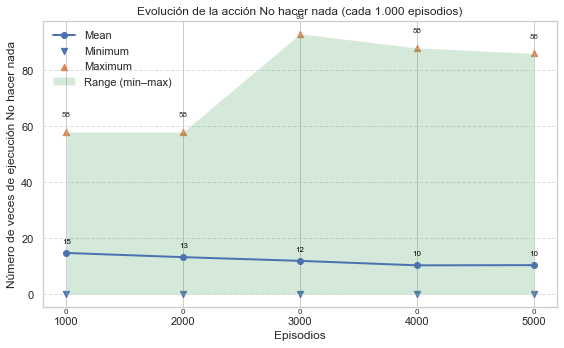

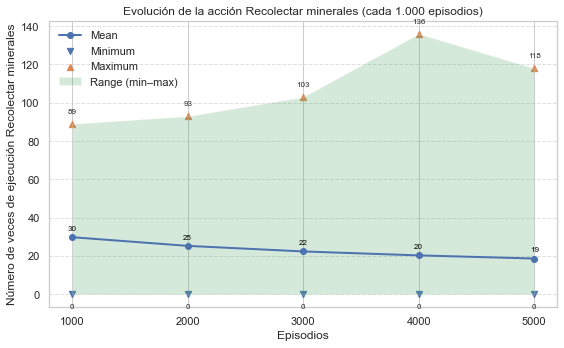

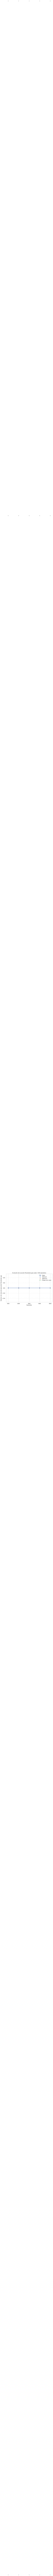

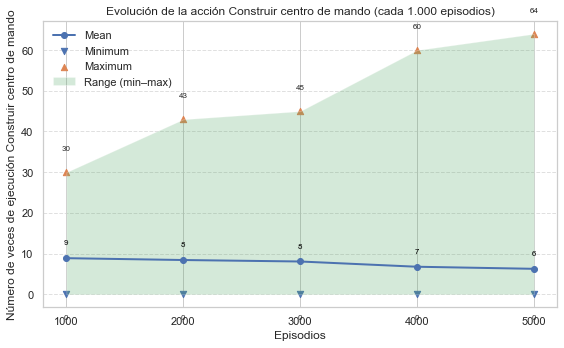

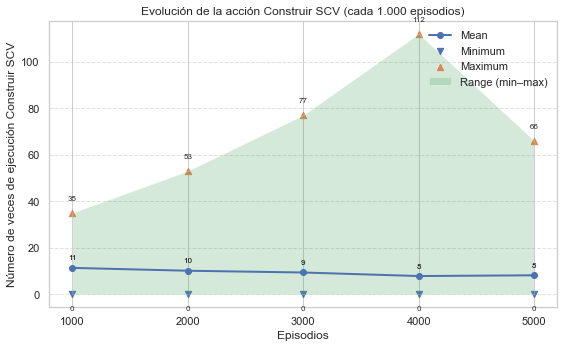

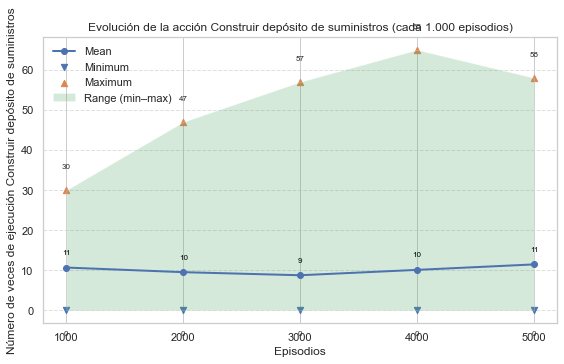

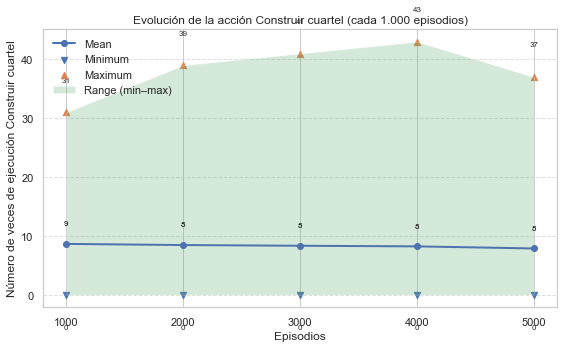

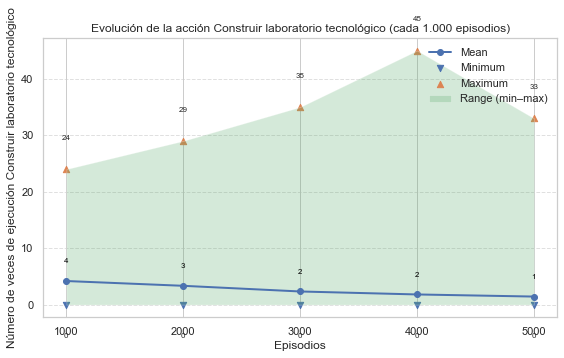

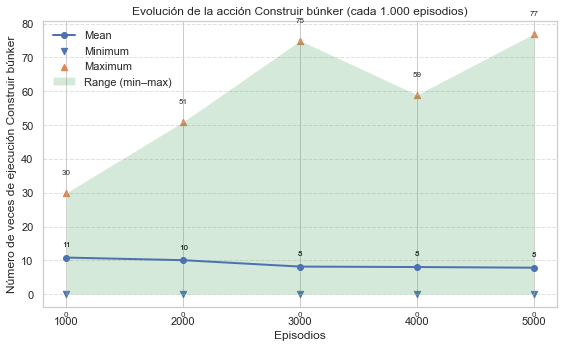

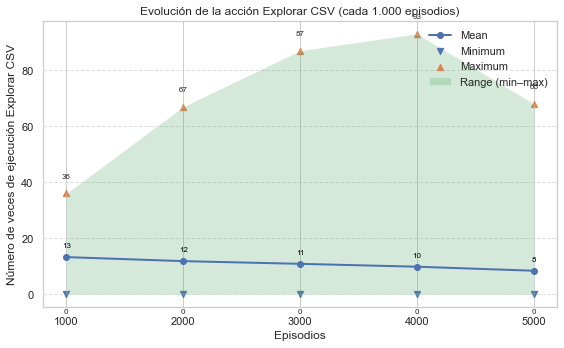

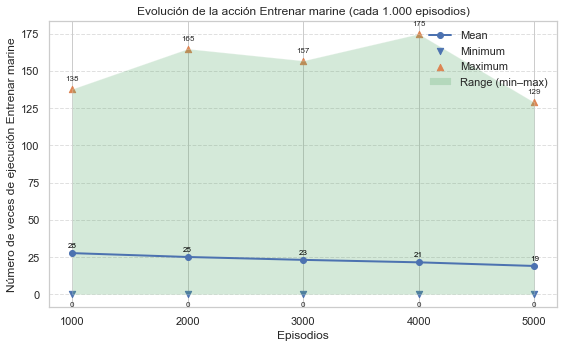

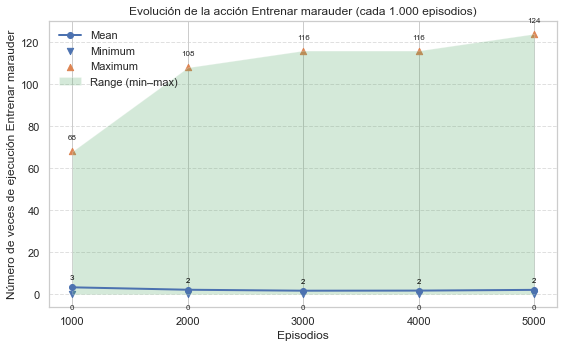

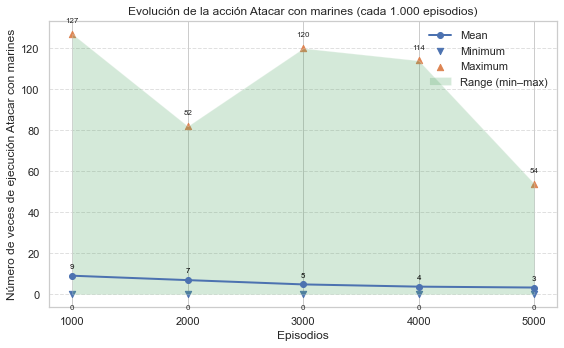

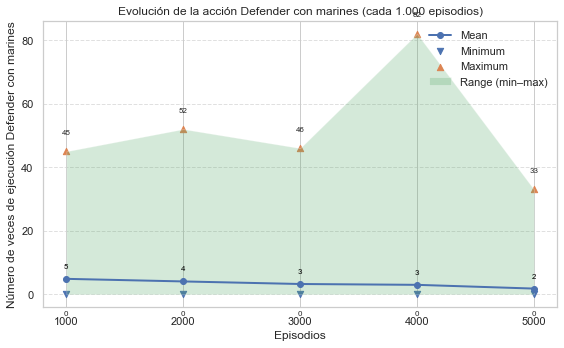

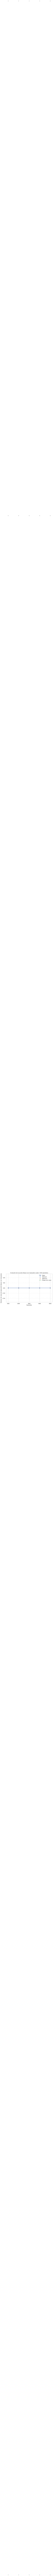

In [109]:
for col in column_actions:
    train_stats = (
        df_aux.groupby("episode_group")
          .agg(
            min=(col, 'min'),
            mean=(col, 'mean'),
            max=(col, 'max')
          )
          .reset_index()
          .rename(columns={"episode_group": "episodes"})
    )
    episodes = train_stats.index.values.astype(int) * N + N

    fig, ax = plt.subplots(figsize=(8, 5))

    # Mean curve
    ax.plot(episodes, train_stats['mean'].values,
            marker='o', linewidth=2, label='Mean')

    # Min & Max points
    ax.scatter(episodes, train_stats['min'].values,
               marker='v', s=40, label='Minimum')
    ax.scatter(episodes, train_stats['max'].values,
               marker='^', s=40, label='Maximum')

    # Range band
    ax.fill_between(episodes,
                    train_stats['min'].values,
                    train_stats['max'].values,
                    alpha=0.25, label='Range (min–max)')

    # Annotate values
    for x, y in zip(episodes, train_stats['min'].values):
        ax.text(x, y - 5, f'{y:.0f}', ha='center', va='top', fontsize=8)

    for x, y in zip(episodes, train_stats['max'].values):
        ax.text(x, y + 5, f'{y:.0f}', ha='center', va='bottom', fontsize=8)

    for x, y in zip(episodes, train_stats['mean'].values):
        ax.text(x, y + 3, f'{y:.0f}', ha='center', va='bottom', fontsize=8, color='black')

    # Labels and formatting in English
    ax.set_title(f"Evolución de la acción {translation_dict[col]} (cada 1.000 episodios)")
    ax.set_xlabel('Episodios')
    ax.set_ylabel(f"Número de veces de ejecución {translation_dict[col]}")
    ax.set_xticks(episodes)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(frameon=False)
    fig.tight_layout()

In [110]:
df_merge_aux = df_merge[[
                'episode', 'epsilon', 'total_steps', 'total_game_time',
                'total_fail', 'count_exploration', 'count_explotation',
                'total_rewards', 'start_datetime', 'fin_datetime', 
                'diff_time_min', 'game_steps', 'scores_y', 'episode_group',
                'victories', 'ties', 'defeats', 'cumsum_victories', 'cumsum_ties',
                'cumsum_defeats', 'victories%', 'ties%', 'defeats%'
]].copy()

df_merge_aux

,episode,epsilon,total_steps,total_game_time,total_fail,count_exploration,count_explotation,total_rewards,start_datetime,fin_datetime,...,episode_group,victories,ties,defeats,cumsum_victories,cumsum_ties,cumsum_defeats,victories%,ties%,defeats%
0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2025-06-28 20:03:06.933600,2025-06-28 20:03:20.573887,...,50,0,0,1,0,0,2,0.0,0.00,100.00
1,2.0,0.999700,977.0,7636.0,482.0,247.0,0.0,-21.231004,2025-06-28 20:03:20.595763,2025-06-28 20:04:03.047496,...,50,0,0,1,0,0,3,0.0,0.00,100.00
2,3.0,0.999400,1586.0,3075.0,349.0,165.0,0.0,-29.444000,2025-06-28 20:04:03.057744,2025-06-28 20:04:30.796540,...,50,0,0,1,0,0,4,0.0,0.00,100.00
3,4.0,0.999100,2135.0,2221.0,351.0,131.0,0.0,-23.818000,2025-06-28 20:04:30.803846,2025-06-28 20:04:54.422820,...,50,0,0,1,0,0,5,0.0,0.00,100.00
4,5.0,0.998801,2732.0,2738.0,319.0,154.0,0.0,-25.843000,2025-06-28 20:04:54.429493,2025-06-28 20:05:18.673663,...,50,0,0,1,0,0,6,0.0,0.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,593.0,0.837277,499089.0,3936.0,409.0,146.0,26.0,-19.949000,2025-06-29 03:37:58.325859,2025-06-29 03:38:25.046880,...,600,0,0,1,0,6,588,0.0,1.01,98.99
593,594.0,0.837026,499868.0,4624.0,385.0,166.0,31.0,-34.227920,2025-06-29 03:38:25.068596,2025-06-29 03:38:56.175711,...,600,0,0,1,0,6,589,0.0,1.01,98.99
594,595.0,0.836775,500518.0,3278.0,384.0,136.0,35.0,-29.479000,2025-06-29 03:38:56.206614,2025-06-29 03:39:19.825662,...,600,0,0,1,0,6,590,0.0,1.01,98.99
595,596.0,0.836524,501323.0,5402.0,365.0,176.0,36.0,-42.522078,2025-06-29 03:39:19.850600,2025-06-29 03:39:51.155630,...,600,0,0,1,0,6,591,0.0,1.01,98.99


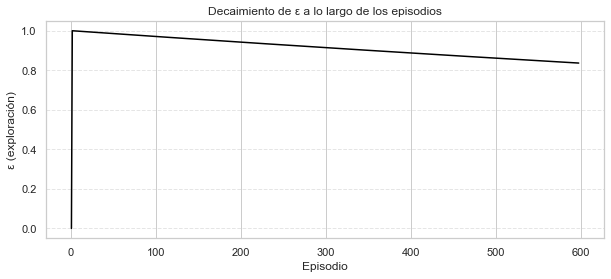

In [111]:
# 1. Evolución de ε a lo largo de los episodios
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_merge_aux,
    x='episode',
    y='epsilon',
    color='black',
    lw=1.5
)
plt.title('Decaimiento de ε a lo largo de los episodios')
plt.xlabel('Episodio')
plt.ylabel('ε (exploración)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

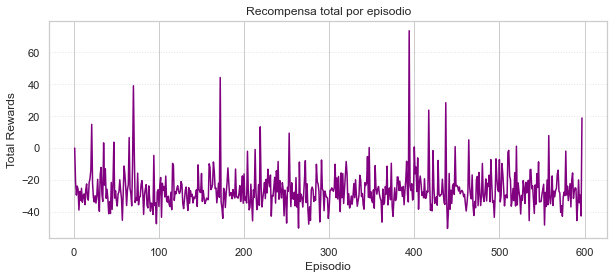

In [112]:
# Recompensas Totales vs Episodios
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_merge_aux,
    x='episode',
    y='total_rewards',
    color='purple'
)
plt.title('Recompensa total por episodio')
plt.xlabel('Episodio')
plt.ylabel('Total Rewards')
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

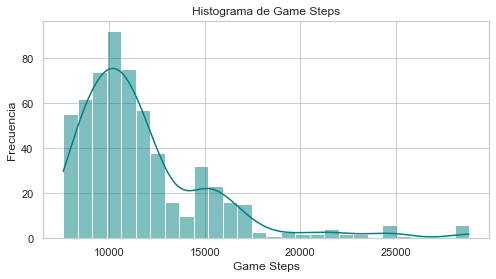

In [113]:
# Distribución de Pasos de Juego
plt.figure(figsize=(8,4))
sns.histplot(
    data=df_merge_aux,
    x='game_steps',
    bins='auto',
    kde=True,
    color='teal'
)
plt.title('Histograma de Game Steps')
plt.xlabel('Game Steps')
plt.ylabel('Frecuencia')
plt.show()

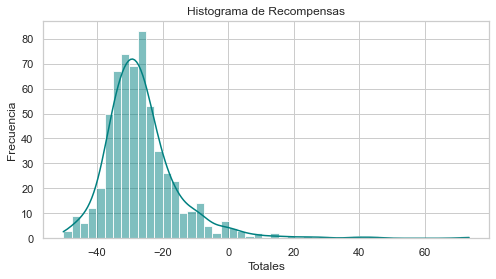

In [114]:
plt.figure(figsize=(8,4))
sns.histplot(
    data=df_merge_aux,
    x='total_rewards',
    bins='auto',
    kde=True,
    color='teal'
)
plt.title('Histograma de Recompensas')
plt.xlabel('Totales')
plt.ylabel('Frecuencia')
plt.show()

In [115]:
df_merge_aux.columns

Index(['episode', 'epsilon', 'total_steps', 'total_game_time', 'total_fail',
       'count_exploration', 'count_explotation', 'total_rewards',
       'start_datetime', 'fin_datetime', 'diff_time_min', 'game_steps',
       'scores_y', 'episode_group', 'victories', 'ties', 'defeats',
       'cumsum_victories', 'cumsum_ties', 'cumsum_defeats', 'victories%',
       'ties%', 'defeats%'],
      dtype='object')

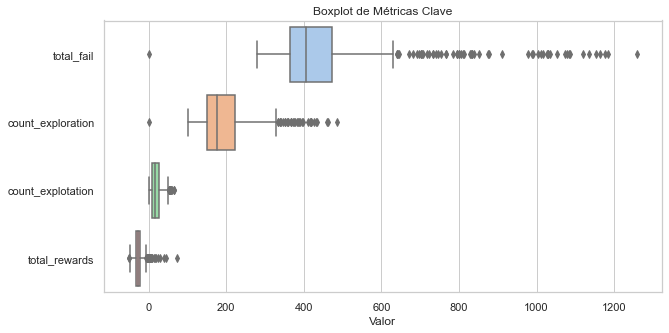

In [116]:
# Boxplot de Distribución de Acciones/Métricas
cols = ['total_fail','count_exploration','count_explotation','total_rewards']
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_merge_aux[cols],
    orient='h',
    palette='pastel'
)
plt.title('Boxplot de Métricas Clave')
plt.xlabel('Valor')
plt.show()

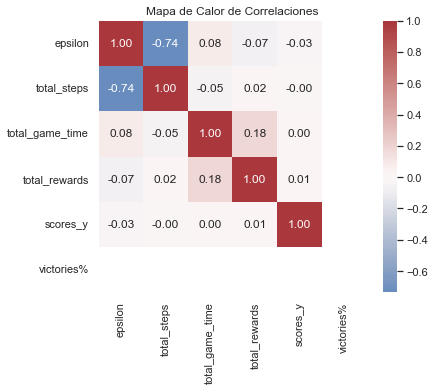

In [117]:
# Heatmap de Correlaciones
numeric = ['epsilon','total_steps','total_game_time','total_rewards','scores_y','victories%']
corr = df_merge_aux[numeric].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

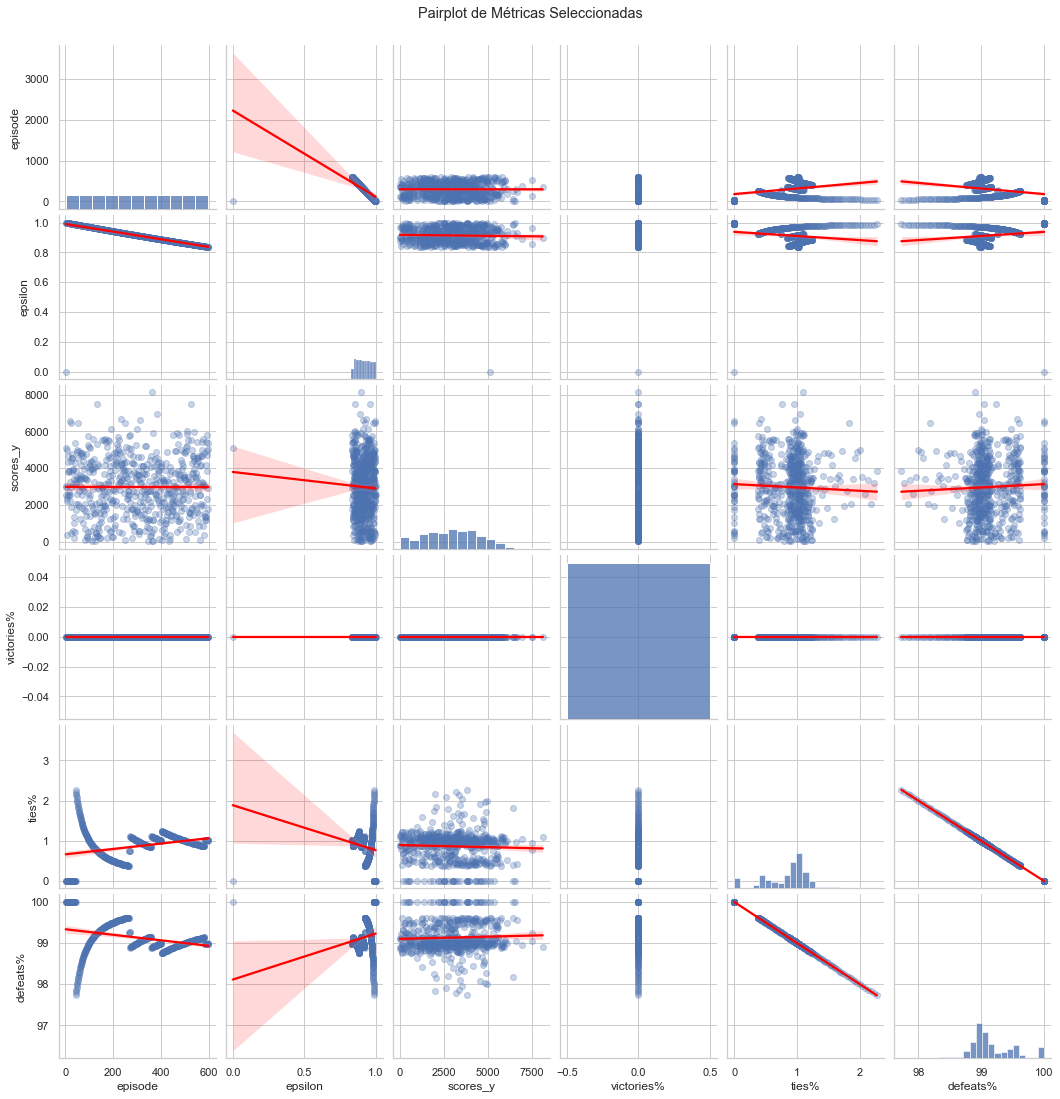

In [118]:
# Pairplot Simplificado
vars_sel = ['episode','epsilon','scores_y','victories%','ties%','defeats%']
sns.pairplot(
    df_merge_aux[vars_sel],
    kind='reg',
    plot_kws={'scatter_kws':{'alpha':0.3}, 'line_kws':{'color':'red'}}
)
plt.suptitle('Pairplot de Métricas Seleccionadas', y=1.02)
plt.show()

# Gráfico Combinado de Métricas Clave por Episodio

A continuación se muestra cómo construir un único **lienzo** con **tres paneles** —uno encima de otro— para visualizar simultáneamente:

1. **Duración** del episodio (`diff_time_min`) y **ε**  
2. **Conteos de exploración**, **explotación** y **fallos** (`count_exploration`, `count_explotation`, `total_fail`)  
3. **Puntuación** vs **recompensa total** (`scores_y`, `total_rewards`), coloreado por resultado y dimensionado por fallos  


ValueError: Could not interpret value `result` for parameter `hue`

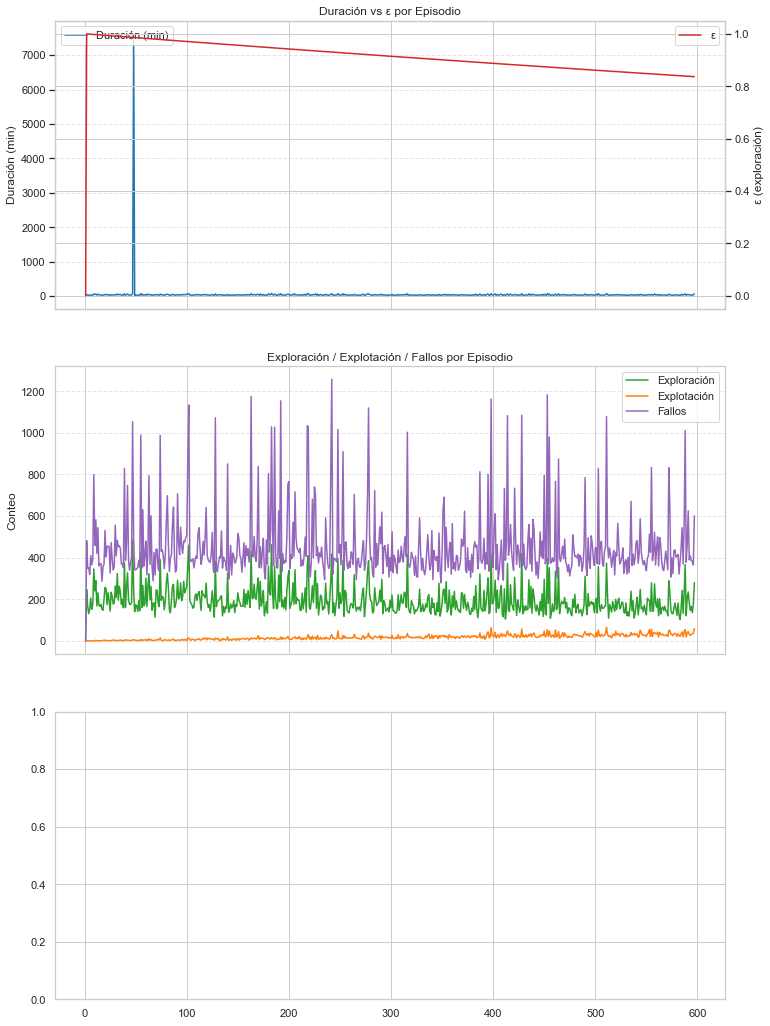

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener df_merge_aux como pandas y la columna 'result'
# df_merge_aux = df_merge_aux.compute()
# df_merge_aux['result'] = df_merge_aux.apply(label_outcome, axis=1)

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# 1) Duración y ε
ax1 = axes[0]
sns.lineplot(data=df_merge_aux, x='episode', y='diff_time_min',
             label='Duración (min)', ax=ax1, color='tab:blue')
ax1b = ax1.twinx()
sns.lineplot(data=df_merge_aux, x='episode', y='epsilon',
             label='ε', ax=ax1b, color='tab:red')
ax1.set_ylabel('Duración (min)')
ax1b.set_ylabel('ε (exploración)')
ax1.set_title('Duración vs ε por Episodio')
ax1.grid(axis='y', ls='--', alpha=0.5)
ax1.legend(loc='upper left')
ax1b.legend(loc='upper right')

# 2) Exploración, Explotación y Fallos
ax2 = axes[1]
sns.lineplot(data=df_merge_aux, x='episode', y='count_exploration',
             label='Exploración', ax=ax2, color='tab:green')
sns.lineplot(data=df_merge_aux, x='episode', y='count_explotation',
             label='Explotación', ax=ax2, color='tab:orange')
sns.lineplot(data=df_merge_aux, x='episode', y='total_fail',
             label='Fallos', ax=ax2, color='tab:purple')
ax2.set_ylabel('Conteo')
ax2.set_title('Exploración / Explotación / Fallos por Episodio')
ax2.grid(axis='y', ls='--', alpha=0.5)
ax2.legend(loc='upper right')

# 3) Score vs Recompensa, coloreado y dimensionado
ax3 = axes[2]
sns.scatterplot(data=df_merge_aux, x='scores_y', y='total_rewards',
                hue='result',
                size='total_fail',
                sizes=(20, 200),
                palette={'Victoria':'green','Empate':'blue','Derrota':'red'},
                alpha=0.6,
                ax=ax3)
ax3.set_xlabel('Score')
ax3.set_ylabel('Total Rewards')
ax3.set_title('Score vs Recompensa Total por Resultado (tamaño de Fallos)')
ax3.legend(title='Resultado', loc='upper left')

# Ajustes finales
plt.tight_layout()
plt.show()

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener df_merge_aux como pandas y la columna 'result' con valores 'Victoria','Empate','Derrota'
# df_merge_aux = df_merge_aux.compute()
# df_merge_aux['result'] = df_merge_aux.apply(label_outcome, axis=1)

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df_merge_aux,
    x='diff_time_min',      # Duración del episodio en minutos
    y='scores_y',           # Score final del episodio
    hue='result',           # Colorea según resultado
    palette={'Victoria':'green','Empate':'blue','Derrota':'red'},
    alpha=0.7,
    edgecolor='w',
    s=50
)

plt.title('Tiempo vs Score por Resultado')
plt.xlabel('Duración del episodio (min)')
plt.ylabel('Score')
plt.legend(title='Resultado', loc='upper left')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `result` for parameter `hue`

<Figure size 720x432 with 0 Axes>

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

# Scatter con tamaño de marcador proporcional a total_rewards
scatter = sns.scatterplot(
    data=df_merge_aux,
    x='diff_time_min',        # Duración del episodio en minutos
    y='scores_y',             # Score final
    hue='result',             # Victoria/Empate/Derrota
    size='total_rewards',     # Tamaño según recompensa total
    sizes=(20, 200),          # Rango de tamaños de marcador
    palette={'Victoria':'green','Empate':'blue','Derrota':'red'},
    alpha=0.7,
    edgecolor='w'
)

plt.title('Duración vs Score por Resultado\n(tamaño vs Recompensas totales)')
plt.xlabel('Duración del episodio (min)')
plt.ylabel('Score')
plt.legend(title='Resultado', loc='upper left')

# Leyenda de tamaño: extraemos los handles y labels del legend de size
handles, labels = scatter.get_legend_handles_labels()
# Filtramos sólo los labels de total_rewards (aparecen tras los de hue)
size_handles = handles[-3:]
size_labels  = labels[-3:]
legend2 = plt.legend(size_handles, size_labels,
                     title='Total Rewards',
                     loc='upper right',
                     labelspacing=1.2,
                     frameon=True)
plt.gca().add_artist(legend2)

plt.tight_layout()
plt.show()


ValueError: Could not interpret value `result` for parameter `hue`

<Figure size 720x432 with 0 Axes>

KeyError: 'result'

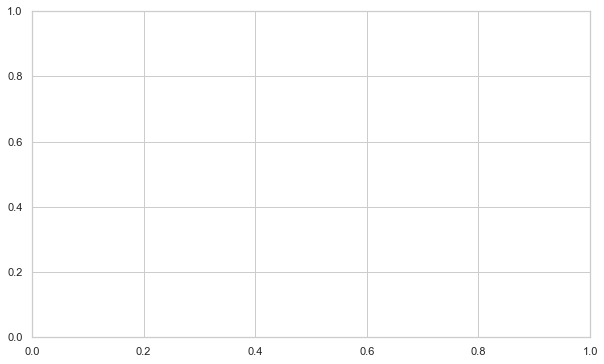

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegúrate de tener df_merge_aux como pandas y con la columna 'result'
# df_merge_aux = df_merge_aux.compute()
# df_merge_aux['result'] = df_merge_aux.apply(label_outcome, axis=1)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6))

# --- OPCIÓN A: Usar tamaño de marcador (bubble chart) y leyenda manual de tamaños ---
# 1) Calcula un factor de escala para los sizes
max_reward = df_merge_aux['total_rewards'].max()
sizes = (df_merge_aux['total_rewards'] / max_reward) * 200  # rango 0–200

# 2) Dibuja el scatter básico, coloreado por resultado
scatter = ax.scatter(
    df_merge_aux['diff_time_min'], 
    df_merge_aux['scores_y'],
    c=df_merge_aux['result'].map({'Victoria':'green','Empate':'blue','Derrota':'red'}),
    s=sizes,
    alpha=0.6,
    edgecolor='w'
)

# 3) Leyenda de resultados
for outcome, color in {'Victoria':'green','Empate':'blue','Derrota':'red'}.items():
    ax.scatter([], [], c=color, alpha=0.6, s=50, label=outcome)

# 4) Leyenda de tamaños (elige muestras representativas)
for rwd in [0.25, 0.5, 0.75, 1.0]:
    ax.scatter([], [], c='gray', alpha=0.6, 
               s=rwd * 200, 
               label=f'{int(rwd * max_reward)} rewards')

ax.legend(scatterpoints=1, frameon=True, title='Resultado / Rewards', 
          labelspacing=1.2, loc='upper right')

ax.set_title('Duración vs Score (tamaño / Total Rewards)')
ax.set_xlabel('Duración del episodio (min)')
ax.set_ylabel('Score')
plt.tight_layout()
plt.show()


# --- OPCIÓN B: Usar color (cmap) para total_rewards y h_


In [259]:
df_merge_aux.columns

Index(['episode', 'epsilon', 'total_steps', 'total_game_time', 'total_fail',
       'count_exploration', 'count_explotation', 'total_rewards',
       'start_datetime', 'fin_datetime', 'diff_time_min', 'game_steps',
       'scores_y', 'episode_group', 'victories', 'ties', 'defeats',
       'cumsum_victories', 'cumsum_ties', 'cumsum_defeats', 'victories%',
       'ties%', 'defeats%', 'result'],
      dtype='object')

In [130]:
df_merge_aux['start_datetime'] = pd.to_datetime(df_merge_aux['start_datetime'])
df_merge_aux['fin_datetime'] = pd.to_datetime(df_merge_aux['fin_datetime'])

df_merge_aux['diff_time'] = df_merge_aux['fin_datetime'] - df_merge_aux['start_datetime']


df_merge_aux['diff_time_seconds'] = df_merge_aux['diff_time'].dt.total_seconds()
hours = df_merge_aux['diff_time_seconds'] // 3600
minutes = (df_merge_aux['diff_time_seconds'] % 3600) // 60
seconds = df_merge_aux['diff_time_seconds'] % 60

df_merge_aux['diff_hours'] = hours.astype(int)
df_merge_aux['diff_minutes'] = minutes.astype(int)
df_merge_aux['diff_seconds'] = seconds.astype(int)

total_seconds_sum =df_merge_aux['diff_time_seconds'].sum()
total_duration = pd.to_timedelta(total_seconds_sum, unit='s')
days = total_duration.days
remaining_seconds_for_hms = total_duration.total_seconds() - (days * 24 * 3600)
hours = int(remaining_seconds_for_hms // 3600)
minutes = int((remaining_seconds_for_hms % 3600) // 60)
seconds = remaining_seconds_for_hms % 60 # Mantener los decimales si es necesario

# Formatear la salida para que se vea bien
output_string = f"{days} días, {hours:02d} horas, {minutes:02d} minutos, {seconds:.3f} segundos"

print(f"\nDesglose de la duración total:")
print(output_string)

# Si necesitas un formato sin los decimales en segundos:
seconds_int = int(seconds)
output_string_int_seconds = f"{days} días, {hours:02d} horas, {minutes:02d} minutos, {seconds_int:02d} segundos"
print(f"Desglose (segundos enteros): {output_string_int_seconds}")


Desglose de la duración total:
0 días, 07 horas, 37 minutos, 36.157 segundos
Desglose (segundos enteros): 0 días, 07 horas, 37 minutos, 36 segundos


In [131]:
df_merge_aux[['start_datetime', 'fin_datetime', 'diff_time', 'diff_hours', 'diff_minutes', 'diff_seconds']].head()

,start_datetime,fin_datetime,diff_time,diff_hours,diff_minutes,diff_seconds
0,2025-06-28 20:03:06.933600,2025-06-28 20:03:20.573887,0 days 00:00:13.640287,0,0,13
1,2025-06-28 20:03:20.595763,2025-06-28 20:04:03.047496,0 days 00:00:42.451733,0,0,42
2,2025-06-28 20:04:03.057744,2025-06-28 20:04:30.796540,0 days 00:00:27.738796,0,0,27
3,2025-06-28 20:04:30.803846,2025-06-28 20:04:54.422820,0 days 00:00:23.618974,0,0,23
4,2025-06-28 20:04:54.429493,2025-06-28 20:05:18.673663,0 days 00:00:24.244170,0,0,24


In [132]:
total_minutes = df_merge_aux.diff_time_min.sum()
time_delta = pd.to_timedelta(total_minutes, unit='minutes')
print(time_delta)

19 days 01:36:09.392580


In [134]:
# Convertir el total de minutos a un objeto Timedelta
# Especificamos la unidad como 'minutes'


# Si quieres acceder a los componentes individuales (días, segundos, etc.):
days = time_delta.days
seconds = time_delta.seconds # segundos restantes después de los días
microseconds = time_delta.microseconds

# Para obtener horas, minutos y segundos del componente 'seconds':
# Puedes convertir los segundos restantes a un objeto datetime.timedelta para una extracción más fácil
from datetime import timedelta
td_seconds = timedelta(seconds=seconds)
hours, remainder = divmod(td_seconds.seconds, 3600)
minutes, seconds_final = divmod(remainder, 60)


print(f"Días: {days}")
print(f"Horas: {hours}")
print(f"Minutos: {minutes}")
print(f"Segundos: {seconds_final}")
print(f"Microsegundos: {microseconds}")

Días: 19
Horas: 1
Minutos: 36
Segundos: 9
Microsegundos: 392580
